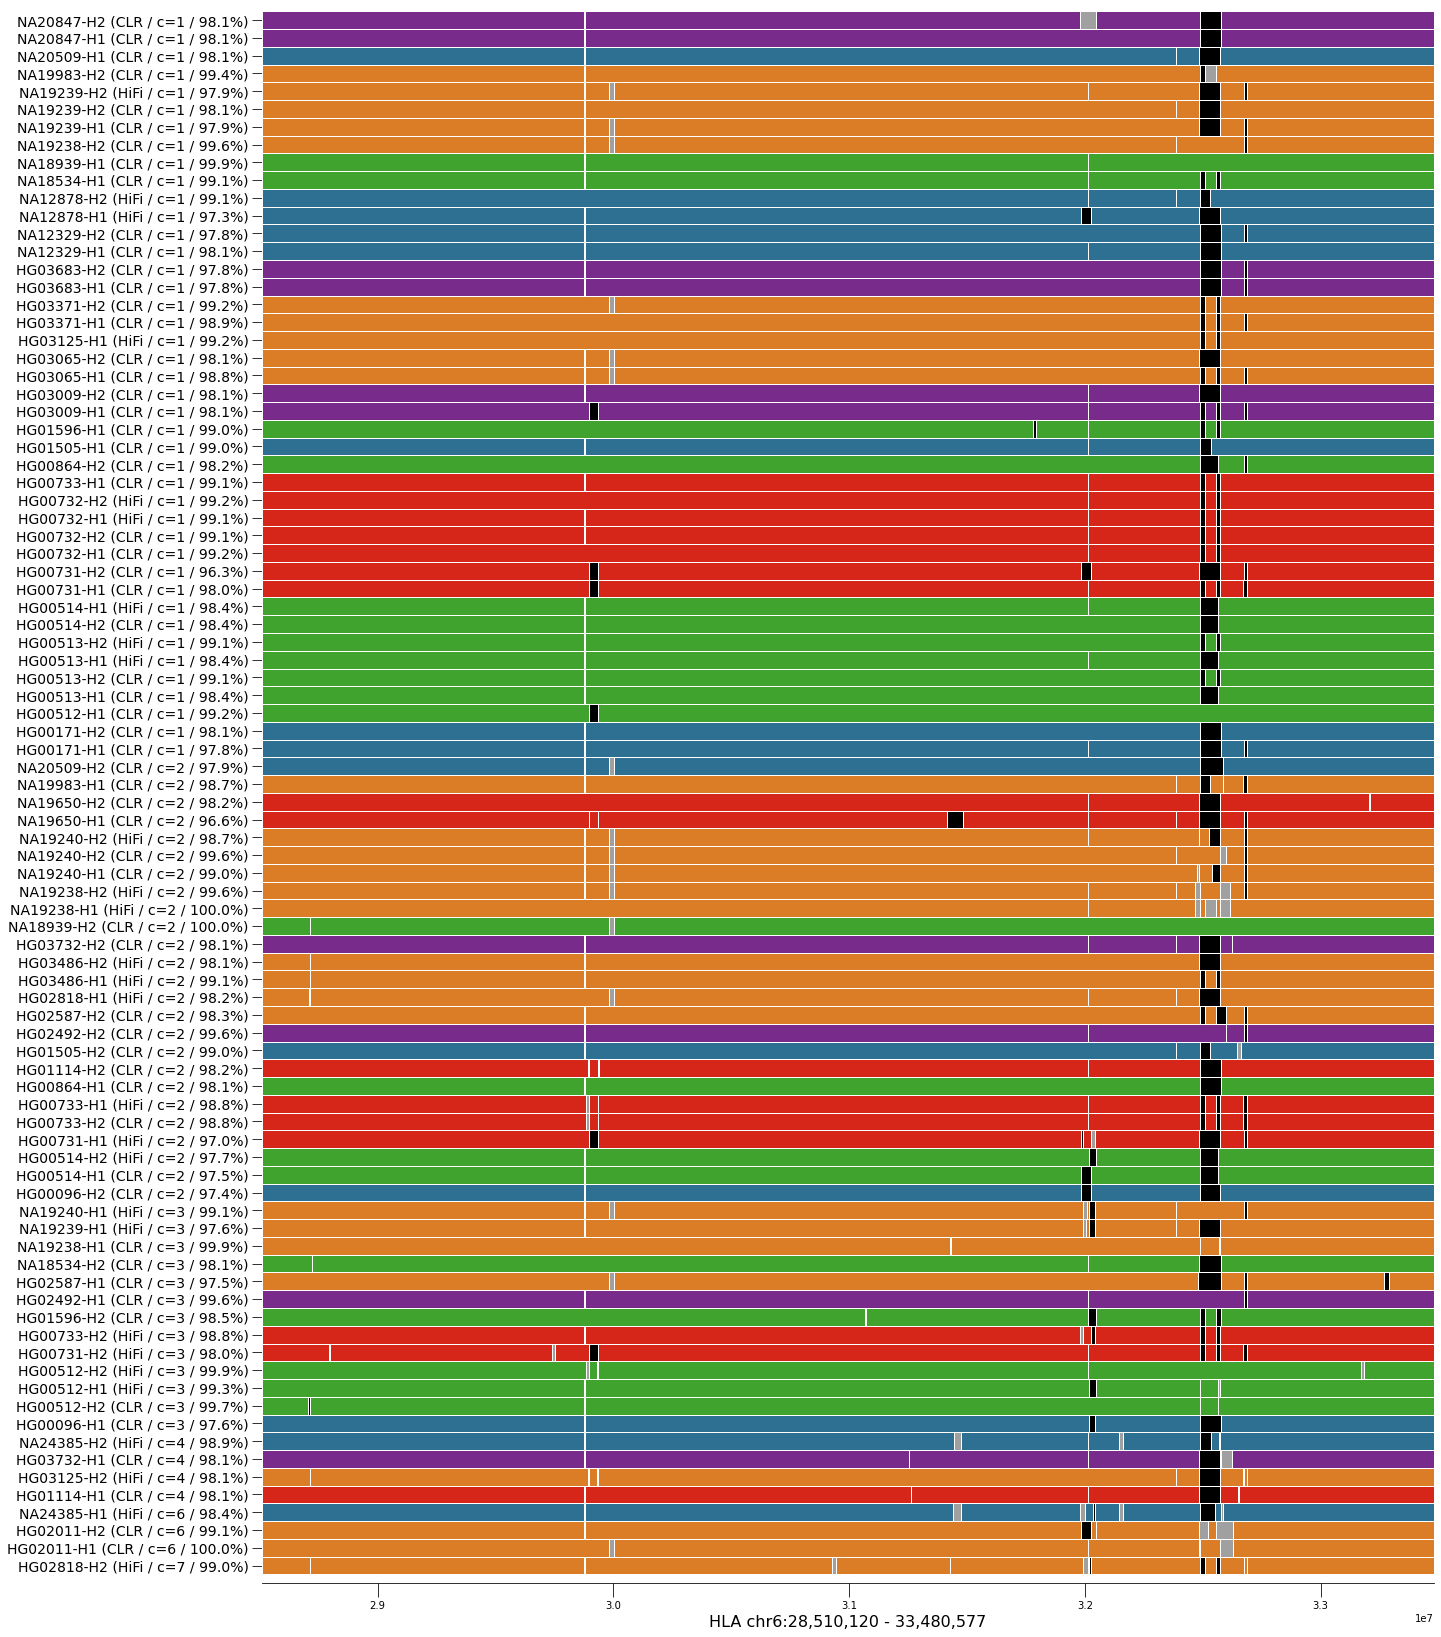

In [8]:
import pandas as pd
import os
import importlib
import re

import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()
prop = plot_aux.get_plot_property

def rgb_rel(rgb):
    return tuple([round(x/255, 3) for x in rgb])

def rel_rgb(rgb):
    return rgb_rel(rgb)

# color definitions
white = (1, 1, 1)
light_blue = rel_rgb([50, 150, 255])
dark_blue = rel_rgb([50, 50, 255])

mustard = rgb_rel([220, 200, 0])
medium_grey = rgb_rel([160, 160, 160])
purple = rgb_rel([150, 0, 150])
red = rgb_rel([255, 0, 0])
light_yellow = rgb_rel([255, 255, 150])
light_orange = rgb_rel([255, 180, 100])
red_hifi = red
red_clr = rgb_rel([155, 0, 0])

all60 = rel_rgb([0,109,44])  # darkest shade
any60 = rel_rgb([49,163,84])
any50 = rel_rgb([116,196,118])
any40 = rel_rgb([186,228,179])
any20 = rel_rgb([237,248,233])  # lightest shade

region_colors = {
    'Gap': medium_grey,
    'Variation': mustard,
    'Unknown': purple,
    'SD_98': light_blue,
    'SD_99': dark_blue,
    'UAB': red,
    'LCaln': light_orange
}


def color_segdups(region_score):
    if region_score < 980:
        return white
    elif 980 <= region_score < 990:
        return light_blue
    elif 990 <= region_score < 1001:
        return dark_blue
    else:
        raise ValueError(region)

def load_annotation(file_path, color=None):
    
    df = pd.read_csv(file_path, sep='\t')
    if 'Issue_Type' in df:
        df['color'] = df['Issue_Type'].apply(lambda x: region_colors[x])
    elif 'chromStart' in df:
        df['color'] = df['score'].apply(color_segdups)
    else:
        assert color is not None, 'no color: {}'.format(file_path)
        df['color'] = df['start'].apply(lambda x: color)
    if 'end' in df:
        df['length'] = df['end'] - df['start']
    if 'chromEnd' in df:
        df['length'] = df['chromEnd'] - df['chromStart']
        df['start'] = df['chromStart']
        df['end'] = df['chromEnd']
        df = df.loc[(df['score'] >= 980), :].copy()
    if '#chrom' in df:
        df['chrom'] = df['#chrom']
    return df

def load_cytogenetic_bands():
    # http://circos.ca/tutorials/lessons/2d_tracks/connectors/configuration
    gie_stain_rgb = {
        'gpos100': (0,0,0),
        'gpos': (0,0,0),
        'gpos75': (130,130,130),
        'gpos66': (160,160,160),
        'gpos50': (200,200,200),
        'gpos33': (210,210,210),
        'gpos25': (200,200,200),
        'gvar': (220,220,220),
        'gneg': (255,255,255),
        'acen': (217,47,39),
        'stalk': (100,127,164)
    }
    gie_stain_frac_rgb = {}
    for k, v in gie_stain_rgb.items():
        gie_stain_frac_rgb[k] = rgb_rel(v)
        path = '/home/local/work/code/github/project-diploid-assembly/annotation/grch38/known_regions'
        cytobands = 'ucsc_cytoband.bed'

        df = pd.read_csv(
            os.path.join(path, cytobands),
            header=0,
            names=['chrom', 'start', 'end', 'name', 'gieStain'],
            sep='\t'
        )
        df['length'] = df['end'] - df['start']
        df['color'] = df['gieStain'].apply(lambda x: rel_rgb(gie_stain_rgb[x]))

    return df

grch38_path = '/home/local/work/code/github/project-diploid-assembly/annotation/grch38'
segdups = os.path.join(grch38_path, 'GRCh38_segdups.bed')

aln_path = '/home/local/work/data/hgsvc/roi/roi_HLA_3q29_blocks.tsv'
aligns = pd.read_csv(aln_path, sep='\t', header=0)
aligns = aligns.loc[aligns['roi'] == 'HLA', :].copy()
aligns.sort_values('block_start', inplace=True)

# Figure stuff
width = 21
height = 29

fig, ax = plt.subplots(figsize=(width, height))

y_start = 0
y_labels = []
y_labels_pos = []
legend_patches = []
max_plot = 0

for num in reversed(sorted(set(aligns['contigs']))):
    sub = aligns.loc[aligns['contigs'] == num, :].copy()
    sub.sort_values('cov_pct',
        ascending=True,
        inplace=True
    )
    
    for (sample, tech, hap), rows in sub.groupby(['sample', 'platform', 'hap']):
        
        contig = rows['contigs'].values[0]
        cov_pct = round(rows['cov_pct'].values[0] * 100, 1)
        
        y_labels.append('{}-{} ({} / c={} / {}%)'.format(sample, hap, tech, contig, cov_pct))
        y_labels_pos.append(y_start + 0.5)
        
        row_blocks = []
        row_colors = []
        
        for idx, row in rows.iterrows():
            row_blocks.append(
                (
                    row['block_start'],
                    row['block_length']
                )
            )
            rgb = row['block_color'].strip('()').split(',')
            rgb = tuple(map(float, rgb))
            row_colors.append(rgb)

        ax.broken_barh(
            row_blocks,
            (y_start, 1),
            edgecolor='white',
            facecolors=row_colors,
            zorder=10
        )
        y_start += 1

# build custom legend
# ax.legend(
#     handles=list(reversed(legend_patches)),
#     loc='best',
#     handlelength=3,
#     handleheight=1,
#     prop={'size': 16}
# )


# # annotate variation in region
# ax.annotate(
#     'HG-2425',
#     (22760989 + 20001, 2.5),  # point
#     (25e6, 2.25),  # text
#     arrowprops=dict(
#         facecolor='black',
#         width=2,
#         headwidth=8,
#         headlength=4
#     ),
#     fontsize=14
# )

_ = ax.set_yticks(y_labels_pos)
_ = ax.set_yticklabels(y_labels, fontsize=14)
#_ = ax.set_xticklabels([])
#_ = ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', length=10)
ax.tick_params(axis='x', which='major', length=10, size=14)


_ = ax.set_xlabel('HLA chr6:28,510,120 - 33,480,577', fontsize=16)
_ = ax.set_xlim(28510120, 33480577)
_ = ax.set_ylim(-0.5, y_start + 0.25)


#out_path = '/home/local/work/data/hgsvc/figSX_panels/ideograms'

#fig.savefig(
#    os.path.join(out_path, 'chr6_HLA_lowres.png'), dpi=150, bbox_inches='tight'
#)

# fig.savefig(
#     os.path.join(out_path, 'chr16p.svg'), bbox_inches='tight'
# )